# Sensitivity/Specificity analysis demo

These are some examples of queries to directly interact with the API to get some metadata:

In [9]:
from cdispyutils.hmac4 import get_auth
import json
import requests
with open('.secrets','r') as f:
    secrets = json.load(f)
auth = get_auth(secrets['access_key'], secrets['secret_key'], 'submission')

In [10]:
print requests.get('http://api.internal.io/v0/submission', auth=auth).text
print requests.get('http://api.internal.io/v0/submission/bpa/', auth=auth).text

{
  "links": [
    "/v0/submission/bpa"
  ]
}
{
  "links": [
    "/v0/submission/bpa/EpicSciences_P001_T1",
    "/v0/submission/bpa/GenomicHealth_P0001_T1",
    "/v0/submission/bpa/Guardant_P0001_T1",
    "/v0/submission/bpa/Novartis_Contrived1_T1",
    "/v0/submission/bpa/PersonalGenome_Beta1",
    "/v0/submission/bpa/ThermoFisher_P0001_T1",
    "/v0/submission/bpa/UMich_P0001_T1",
    "/v0/submission/bpa/UMich_P0002_T1",
    "/v0/submission/bpa/USC_OPT1_T1",
    "/v0/submission/bpa/ThermoFisher_P0002_T1",
    "/v0/submission/bpa/test"
  ]
}


In [11]:
data = {'query': """query Test { sample (project_id: "bpa-ThermoFisher_P0001_T1", submitter_id: "BPA-THERMOFISHER_P0001-S1") {   
                                 _aliquots_count aliquots { aliquot_concentration  _read_groups_count read_groups {
                                _submitted_somatic_mutations_count submitted_somatic_mutations {
                                file_name}} } }} """};
print requests.post('http://api.internal.io/v0/submission/graphql/', auth=auth, json=data).text

{
  "data": {
    "experiment": [
      {
        "experimental_description": "Detection of Rare Variants in cfDNA Control",
        "experimental_intent": "analytical validation",
        "number_samples_per_experimental_group": 32,
        "type_of_sample": "contrived",
        "type_of_specimen": "DNA"
      }
    ]
  }
}


This example shows how to analyze data from one specific project in BloodPAC containing expected mutations from contrived samples and resulting VCF files

In [4]:
import bpa_analysis_functions_v2 as bp

Get the project name we are going to analyze, local path to save project files and user profile to access their bucket:

In [5]:
project = 'bpa-ThermoFisher_P0001_T1'
profile = 'bloodpac'
path    = 'files/'

Get project files from bucket to a local directory:

In [6]:
bp.get_files_from_bucket(project, profile, path)

Getting files...
Finished


List samples for this project:

In [15]:
samples = bp.list_samples(project)
samples

['BPA-THERMOFISHER_P0001-S1',
 'BPA-THERMOFISHER_P0001-S2',
 'BPA-THERMOFISHER_P0001-S3',
 'BPA-THERMOFISHER_P0001-S4']

List and count file types contained in this project

In [16]:
vcf_files = bp.list_files_by_type(project,'VCF', samples[1])
vcf_files

{'BPA-THERMOFISHER_P0001-S2': ['TFS.HZ.1.0.perc_10ng_TSVC_IonCodeTag_0112.vcf',
  'TFS.HZ.1.0.perc_10ng_TSVC_IonXpress_03.vcf',
  'TFS.HZ.1.0.perc_10ng_TSVC_IonCodeTag_0111.vcf',
  'TFS.HZ.1.0.perc_10ng_TSVC_IonXpress_04.vcf',
  'TFS.HZ.1.0.perc_5ng_TSVC_IonXpress_01.vcf',
  'TFS.HZ.1.0.perc_5ng_TSVC_IonCodeTag_0109.vcf',
  'TFS.HZ.1.0.perc_5ng_TSVC_IonCodeTag_0110.vcf',
  'TFS.HZ.1.0.perc_5ng_TSVC_IonXpress_02.vcf',
  'TFS.HZ.1.0.perc_20ng_TSVC_IonXpress_013.vcf',
  'TFS.HZ.1.0.perc_20ng_TSVC_IonCodeTag_0106.vcf',
  'TFS.HZ.1.0.perc_20ng_TSVC_IonCodeTag_0105.vcf',
  'TFS.HZ.1.0.perc_20ng_TSVC_IonXpress_014.vcf']}

In [17]:
counts = bp.count_file_types(project, samples[1])
counts

{'vcf': 12}

Get expected mutations from sample-expectation metadata:

In [18]:
expectation = bp.get_expected_mutations(project)
expectation

[{'expected_mutation_chromosome': '12',
  'expected_mutation_position': '25398284',
  'sample_id': 'BPA-THERMOFISHER_P0001-S1'},
 {'expected_mutation_chromosome': '15',
  'expected_mutation_position': '66727451',
  'sample_id': 'BPA-THERMOFISHER_P0001-S1'},
 {'expected_mutation_chromosome': '1',
  'expected_mutation_position': '115256530',
  'sample_id': 'BPA-THERMOFISHER_P0001-S1'},
 {'expected_mutation_chromosome': '7',
  'expected_mutation_position': '55248998',
  'sample_id': 'BPA-THERMOFISHER_P0001-S1'},
 {'expected_mutation_chromosome': '7',
  'expected_mutation_position': '55259515',
  'sample_id': 'BPA-THERMOFISHER_P0001-S1'},
 {'expected_mutation_chromosome': '3',
  'expected_mutation_position': '178952085',
  'sample_id': 'BPA-THERMOFISHER_P0001-S1'},
 {'expected_mutation_chromosome': '3',
  'expected_mutation_position': '178936091',
  'sample_id': 'BPA-THERMOFISHER_P0001-S1'},
 {'expected_mutation_chromosome': '1',
  'expected_mutation_position': '115256536',
  'sample_id': 

Calculate sensitivity and sensitivity values for one example VCF:

In [19]:
sample = samples[1]
vcf_file = vcf_files[sample][2]
metrics = bp.calculate_metrics_vcf(project, path, vcf_file, sample)
metrics

{'Expectations': 12,
 'False-Positive': 6,
 'Sensitivity': 0.667,
 'Specificity': 0.963,
 'True-Positive': 8,
 'VCF File': 'TFS.HZ.1.0.perc_10ng_TSVC_IonCodeTag_0111.vcf'}

Calculate sensitivity and sensitivity values for all VCFs in the project:

In [20]:
table_metrics, data_metrics = bp.calculate_metrics_all_vcf(project, path, vcf_files)
table_metrics

TFS.HZ.1.0.perc_10ng_TSVC_IonCodeTag_0112.vcf,12,8,5,0.667,0.969
TFS.HZ.1.0.perc_10ng_TSVC_IonXpress_03.vcf,12,8,0,0.667,1.0
TFS.HZ.1.0.perc_10ng_TSVC_IonCodeTag_0111.vcf,12,8,6,0.667,0.963
TFS.HZ.1.0.perc_10ng_TSVC_IonXpress_04.vcf,12,8,0,0.667,1.0
TFS.HZ.1.0.perc_5ng_TSVC_IonXpress_01.vcf,12,6,0,0.5,1.0
TFS.HZ.1.0.perc_5ng_TSVC_IonCodeTag_0109.vcf,12,7,1,0.583,0.994
TFS.HZ.1.0.perc_5ng_TSVC_IonCodeTag_0110.vcf,12,8,6,0.667,0.963
TFS.HZ.1.0.perc_5ng_TSVC_IonXpress_02.vcf,12,8,0,0.667,1.0
TFS.HZ.1.0.perc_20ng_TSVC_IonXpress_013.vcf,12,8,1,0.667,0.994
TFS.HZ.1.0.perc_20ng_TSVC_IonCodeTag_0106.vcf,12,8,0,0.667,1.0
TFS.HZ.1.0.perc_20ng_TSVC_IonCodeTag_0105.vcf,12,8,1,0.667,0.994


In [21]:
baseline_vcf = 'TFS.HZ.0.0.perc_20ng_TSVC_IonCodeTag_0101.vcf'
table_filter_metrics, data_filter_metrics = bp.calculate_metrics_all_vcf(project, path, vcf_files, baseline_vcf)
table_filter_metrics

TFS.HZ.1.0.perc_10ng_TSVC_IonCodeTag_0112.vcf,8,8,5,1.0,0.969
TFS.HZ.1.0.perc_10ng_TSVC_IonXpress_03.vcf,8,8,0,1.0,1.0
TFS.HZ.1.0.perc_10ng_TSVC_IonCodeTag_0111.vcf,8,8,6,1.0,0.963
TFS.HZ.1.0.perc_10ng_TSVC_IonXpress_04.vcf,8,8,0,1.0,1.0
TFS.HZ.1.0.perc_5ng_TSVC_IonXpress_01.vcf,8,6,0,0.75,1.0
TFS.HZ.1.0.perc_5ng_TSVC_IonCodeTag_0109.vcf,8,7,1,0.875,0.994
TFS.HZ.1.0.perc_5ng_TSVC_IonCodeTag_0110.vcf,8,8,6,1.0,0.963
TFS.HZ.1.0.perc_5ng_TSVC_IonXpress_02.vcf,8,8,0,1.0,1.0
TFS.HZ.1.0.perc_20ng_TSVC_IonXpress_013.vcf,8,8,1,1.0,0.994
TFS.HZ.1.0.perc_20ng_TSVC_IonCodeTag_0106.vcf,8,8,0,1.0,1.0
TFS.HZ.1.0.perc_20ng_TSVC_IonCodeTag_0105.vcf,8,8,1,1.0,0.994


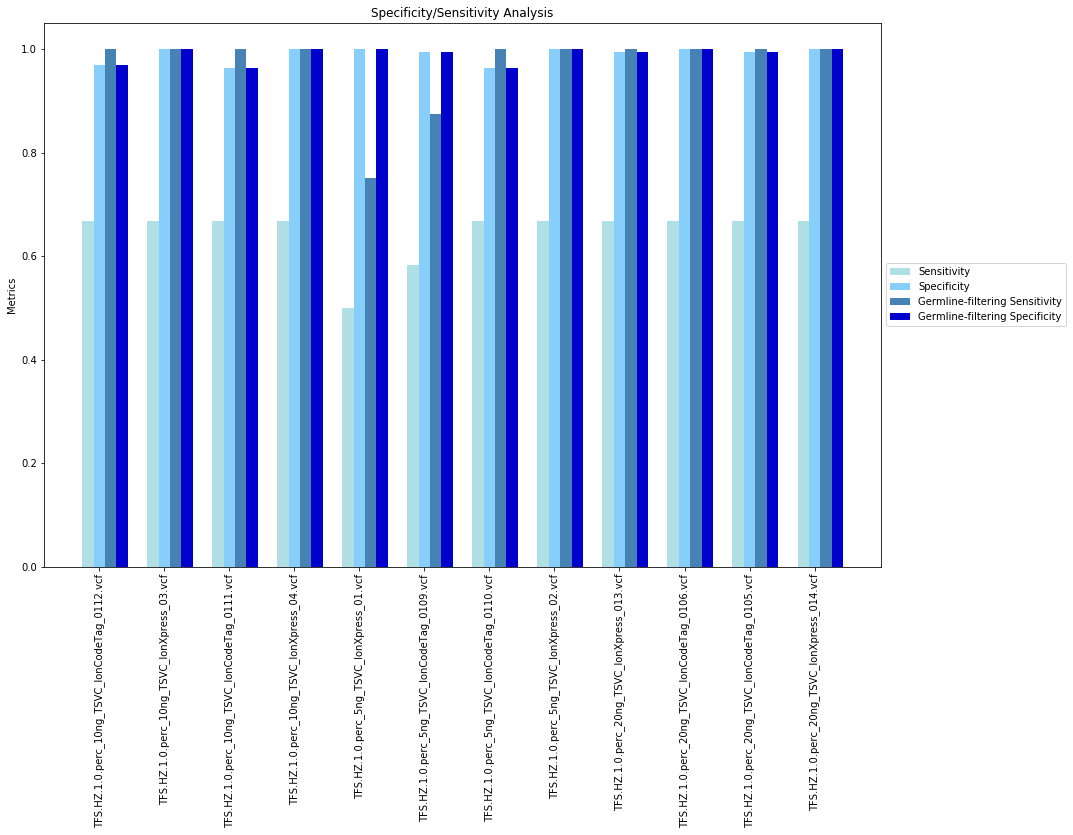

In [22]:
bp.plot_metrics(data_metrics, data_filter_metrics)